In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('Stationary.csv')
df.head()

,Month,production,diff_1,Retrive
0,1956-01,93.2,0.125895,93.2
1,1956-02,96.0,2.800000,96.0
2,1956-03,95.2,-0.800000,95.2
3,1956-04,77.1,-18.100000,77.1
4,1956-05,70.9,-6.200000,70.9


In [3]:
df.rename(columns = {'diff_1':'value'}, inplace = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       476 non-null    object 
 1   production  476 non-null    float64
 2   value       476 non-null    float64
 3   Retrive     476 non-null    float64
dtypes: float64(3), object(1)
memory usage: 15.0+ KB


In [5]:
df.shape

(476, 4)

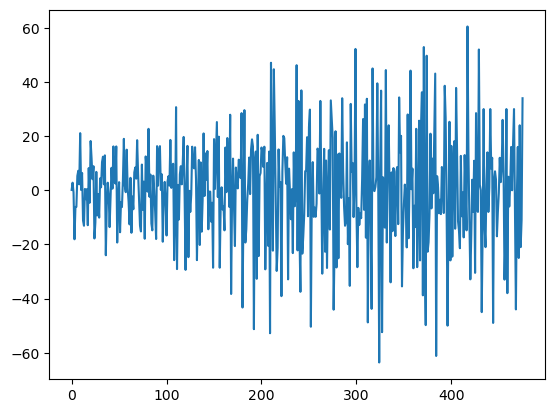

In [6]:
plt.plot(df['value'])
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['value2']=scaler.fit_transform(df[['value']])

C:\Users\user\.conda\envs\panadas-tutorial\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


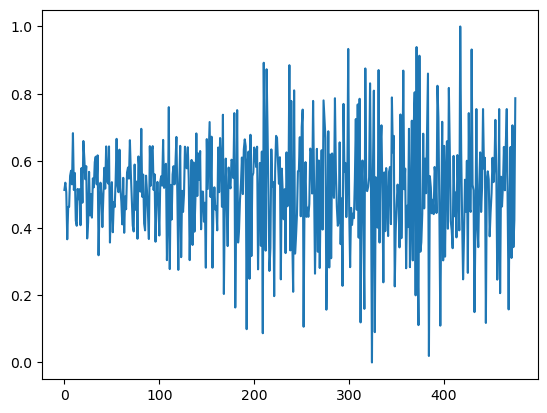

In [8]:
plt.plot(df['value2'])
plt.show()

In [10]:
r_d=scaler.inverse_transform(np.array(df['value2']).reshape(-1,1))

r_d

array([[  0.12589474],
       [  2.8       ],
       [ -0.8       ],
       [-18.1       ],
       [ -6.2       ],
       [ -6.1       ],
       [  5.3       ],
       [  7.2       ],
       [  2.2       ],
       [ 21.1       ],
       [  0.1       ],
       [  6.4       ],
       [-11.2       ],
       [-13.1       ],
       [  0.5       ],
       [ -3.3       ],
       [  0.4       ],
       [-12.9       ],
       [  8.2       ],
       [ -4.6       ],
       [ 18.2       ],
       [ 11.8       ],
       [  4.1       ],
       [  8.9       ],
       [-17.8       ],
       [-11.9       ],
       [  6.8       ],
       [ -9.3       ],
       [ -1.4       ],
       [-10.1       ],
       [  4.4       ],
       [  1.1       ],
       [ 10.4       ],
       [ 12.4       ],
       [  2.2       ],
       [ 12.9       ],
       [-24.        ],
       [ -5.4       ],
       [  2.8       ],
       [ -1.6       ],
       [-13.6       ],
       [ -2.8       ],
       [  8.3       ],
       [  0

In [11]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense,Flatten
from tensorflow.python.keras.layers import LSTM

In [12]:
# let us build this function

def split_sequence(sequence,steps):
    x,y=list(),list()
    for start in range(len(sequence)):
        end_index=start+steps
        if end_index > len(sequence)-1:
            break;
        sequence_x,sequence_y=sequence[start:end_index],sequence[end_index]
        x.append(sequence_x)
        y.append(sequence_y)
    return array(x),array(y)

In [13]:
# now do the same for our original data & 3 month lag

d=df['value2'].tolist()

steps=10
x,y=split_sequence(d,steps)

In [14]:
#reshape 2d data to 3d to fit in cnn
features=1
x=x.reshape((x.shape[0],x.shape[1],features))

print(x.shape)

(466, 10, 1)


In [15]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(50, return_sequences=True, input_shape=(x.shape[1],1)))
#Add second layer to model
model.add(LSTM(50, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(25))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

In [16]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
# fit model

model.fit(x,y,epochs=600,verbose=0)

In [24]:
test_data_x= x[-120:]
test_data_y= y[-120:]

In [25]:
test_data_pred=model.predict(test_data_x)

4/4 [==============================] - 0s 12ms/step


In [26]:
test_data_pred.shape

(120, 1)

In [27]:
from sklearn.metrics import r2_score

r2_score(test_data_y,test_data_pred)

0.982995674514375

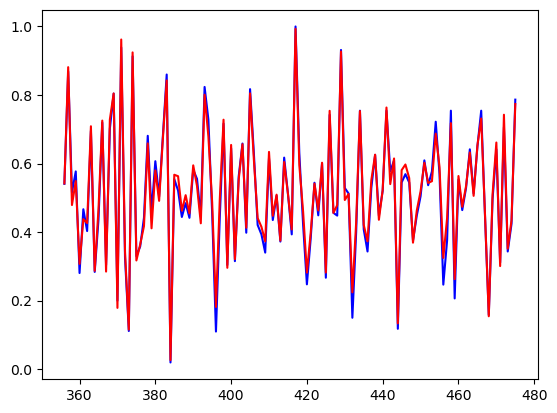

In [28]:
plt.plot(df.tail(120).index, test_data_y, color='blue')
plt.plot(df.tail(120).index, test_data_pred, color='red')
plt.show()

In [29]:
df.tail()

,Month,production,value,Retrive,value2
471,1995-04,127.0,-25.0,127.0,0.311039
472,1995-05,151.0,24.0,151.0,0.705882
473,1995-06,130.0,-21.0,130.0,0.343272
474,1995-07,119.0,-11.0,119.0,0.423852
475,1995-08,153.0,34.0,153.0,0.786463


In [30]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def increase_month(date_string):
    date_obj = datetime.strptime(date_string, "%Y-%m")
    new_date_obj = date_obj + relativedelta(months=1)
    formatted_date = datetime.strftime(new_date_obj, "%Y-%m")
    return formatted_date 

start_month = '1995-08'
increase_month(start_month)

'1995-09'

In [31]:
# forecasting 24 months future data

data=df['value2'].tolist()
forecasted_df=pd.DataFrame(columns=['Month','value2'])
start_month = '1995-07'

for i in range(24):
    new_month=increase_month(start_month)
    forecast_input=array(data[-10:])
    x_forecast=forecast_input.reshape(1,steps,features)
    forecasted_y=model.predict(x_forecast).item()
    #print(np.array(forecasted_y))
    #x=np.concatenate((x,np.array(x_forecast)))
    #y=np.concatenate((y,np.array([forecasted_y])))
    #model.fit(x,y,epochs=5,verbose=0)
    forecasted_df.at[i,'Month']=new_month
    forecasted_df.at[i,'value2']=forecasted_y
    data.append(forecasted_y)
    start_month=new_month

1/1 [==============================] - 0s 25ms/step


In [32]:
forecasted_df

,Month,value2
0,1995-08,0.680158
1,1995-09,0.391424
2,1995-10,0.646684
3,1995-11,0.282245
4,1995-12,0.543732
5,1996-01,0.763241
6,1996-02,0.148353
7,1996-03,0.295321
8,1996-04,0.762729
9,1996-05,0.285496


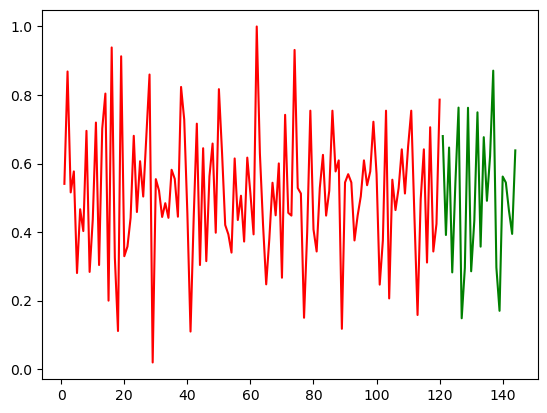

In [33]:
index_old=np.arange(1,121)
index_new=np.arange(121,145)

plt.plot(index_old, test_data_y, color='red')
plt.plot(index_new,forecasted_df['value2'], color='green')

In [34]:
forcasted_dif=scaler.inverse_transform(np.array(forecasted_df['value2']).reshape(-1,1))

In [35]:
dif_list=np.array(forcasted_dif).flatten().tolist()

dif_list

[20.80758057832717,
 -15.024325948953633,
 16.653438895940774,
 -28.57345341742039,
 3.8771914243698054,
 31.118236821889866,
 -45.18937846273184,
 -26.950691315531735,
 31.054711931943885,
 -28.169917249679568,
 -9.886584043502813,
 29.40397461652755,
 -19.246793133020404,
 20.406614845991125,
 -2.6343723863363326,
 13.559825575351708,
 44.500160241127006,
 -26.795152235031132,
 -42.489846175909044,
 6.148265415430062,
 3.966132187843316,
 -6.3277182161808065,
 -14.630139508843426,
 15.616240471601477]

In [36]:
last_value=df.tail(1)['production'].iloc[0]

last_value

#print(last_value+dif_list[1])

153.0

In [37]:
forecasted_og=[]

for i in range(len(dif_list)):
    n=last_value+dif_list[i]
    forecasted_og.append(n)
    last_value=n
    
forecasted_df['Retrive']=forecasted_og

In [38]:
forecasted_df

,Month,value2,Retrive
0,1995-08,0.680158,173.807581
1,1995-09,0.391424,158.783255
2,1995-10,0.646684,175.436694
3,1995-11,0.282245,146.863240
4,1995-12,0.543732,150.740432
5,1996-01,0.763241,181.858668
6,1996-02,0.148353,136.669290
7,1996-03,0.295321,109.718599
8,1996-04,0.762729,140.773311
9,1996-05,0.285496,112.603393


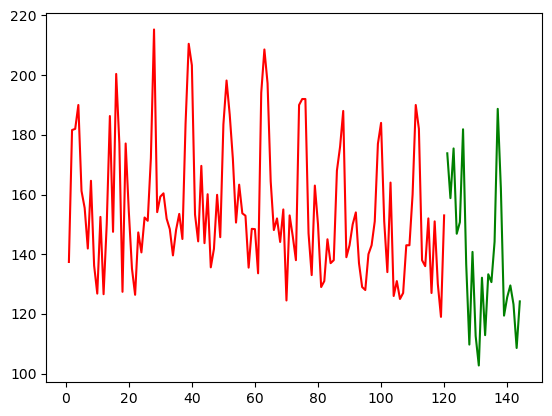

In [39]:
index_old=np.arange(1,121)
index_new=np.arange(121,145)

last_300 = df['production'][-120:].tolist()

plt.plot(index_old, last_300, color='red')
plt.plot(index_new,forecasted_df['Retrive'], color='green')

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Save the model to a file
tf.keras.models.save_model(model, 'my_lstm_model')

INFO:tensorflow:Assets written to: my_lstm_model\assets


In [92]:
df.to_csv("last10Data.csv")

In [94]:
predict_array = forecasted_df.values
predict_array

array([['1995-08', 0.46441975235939026, 28.034491267800327],
       ['1995-09', 0.68299400806427, 49.19404766857623],
       ['1995-10', 0.5711694359779358, 56.47617467343806],
       ['1995-11', 0.5025127530097961, 55.23800732195375],
       ['1995-12', 0.30703604221343994, 29.741180160641647],
       ['1996-01', 0.5050912499427795, 28.823004278540584],
       ['1996-02', 0.5500249862670898, 33.481105074286425],
       ['1996-03', 0.5101125836372375, 33.1860767036676],
       ['1996-04', 0.3242631256580353, 9.827130597829775],
       ['1996-05', 0.6055411100387573, 21.374782353639553],
       ['1996-06', 0.56592857837677, 28.006518930196705],
       ['1996-07', 0.4990866482257843, 26.34317197501653],
       ['1996-08', 0.6413305401802063, 42.332292011380126],
       ['1996-09', 0.6323630809783936, 57.20855036079876],
       ['1996-10', 0.514418363571167, 57.44786927998058],
       ['1996-11', 0.4561084806919098, 50.45093173384658],
       ['1996-12', 0.3506752550601959, 30.36973088681

In [42]:
df.tail()

,Month,production,value,Retrive,value2
471,1995-04,127.0,-25.0,127.0,0.311039
472,1995-05,151.0,24.0,151.0,0.705882
473,1995-06,130.0,-21.0,130.0,0.343272
474,1995-07,119.0,-11.0,119.0,0.423852
475,1995-08,153.0,34.0,153.0,0.786463
